In [47]:
import sys
sys.path.append('../scripts')
import pandas as pd
import proplot as pplt
import matplotlib as mpl
import os
from helpers import *
import xarray as xr
import numpy as np

def print(*val):
    display(*val)

In [40]:
def best_from_station(station_df):
    tbuoys = station_df[station_df["Buoy Type"] == "Thermistor"]
    if len(tbuoys) > 0:
        return tbuoys.idxmax().loc["length"]
    else:
        return station_df.idxmax().loc["length"]

for dir in ["../data/daily_stations",
            "../data/daily_stations/mosaic_dn1",
            "../data/daily_stations/mosaic_dn2"]:
    if not os.path.exists(dir):
        os.makedirs(dir)

In [41]:
buoy_meta = buoy_metadata()
all_buoys = buoy_meta.index.to_list()

valid_buoys = buoy_meta[buoy_meta["Interp"] == True].index
interp_lens = pd.DataFrame([{"Sensor ID": buoy, 
                             "length": buoy_data(buoy)["datetime"].max() - buoy_data(buoy)["datetime"].min()} 
                             for buoy in valid_buoys])
interp_lens = interp_lens.set_index("Sensor ID")

valid_buoy_meta = buoy_meta.merge(interp_lens, how="right", left_index=True, right_index=True)

grouped_stations = valid_buoy_meta[["DN Station ID", "Buoy Type", "length"]].groupby("DN Station ID")

In [42]:
best_buoys = []
for station in grouped_stations:
    #if station[0] == "CO1":
    #    test = station[1].head(2)
    #    for sensor in test.index:
    #        print(buoy_data(sensor))

    station_buoy = best_from_station(station[1])
    downsample_data = buoy_data(station_buoy).set_index("datetime").resample("1d", offset="12h").asfreq().dropna()
    downsample_data_mn = buoy_data(station_buoy).set_index("datetime").resample("1d").asfreq().dropna()
    
    dn = 2 if buoy_metadata().loc[station_buoy, "Deployment Leg"] == 5 else 1
    downsample_data.to_csv(f"../data/daily_stations/mosaic_dn{dn}/{station[0]}.csv")
    best_buoys.append([station[0], station_buoy, buoy_meta.loc[station_buoy, "Deployment Leg"]])

pd.DataFrame(best_buoys, columns=["Station ID", "sensor_id", "Deployment Leg"]).set_index("Station ID").to_csv("../data/metadata/station_metadata.csv")

In [39]:
%run ../scripts/process_stations.py

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


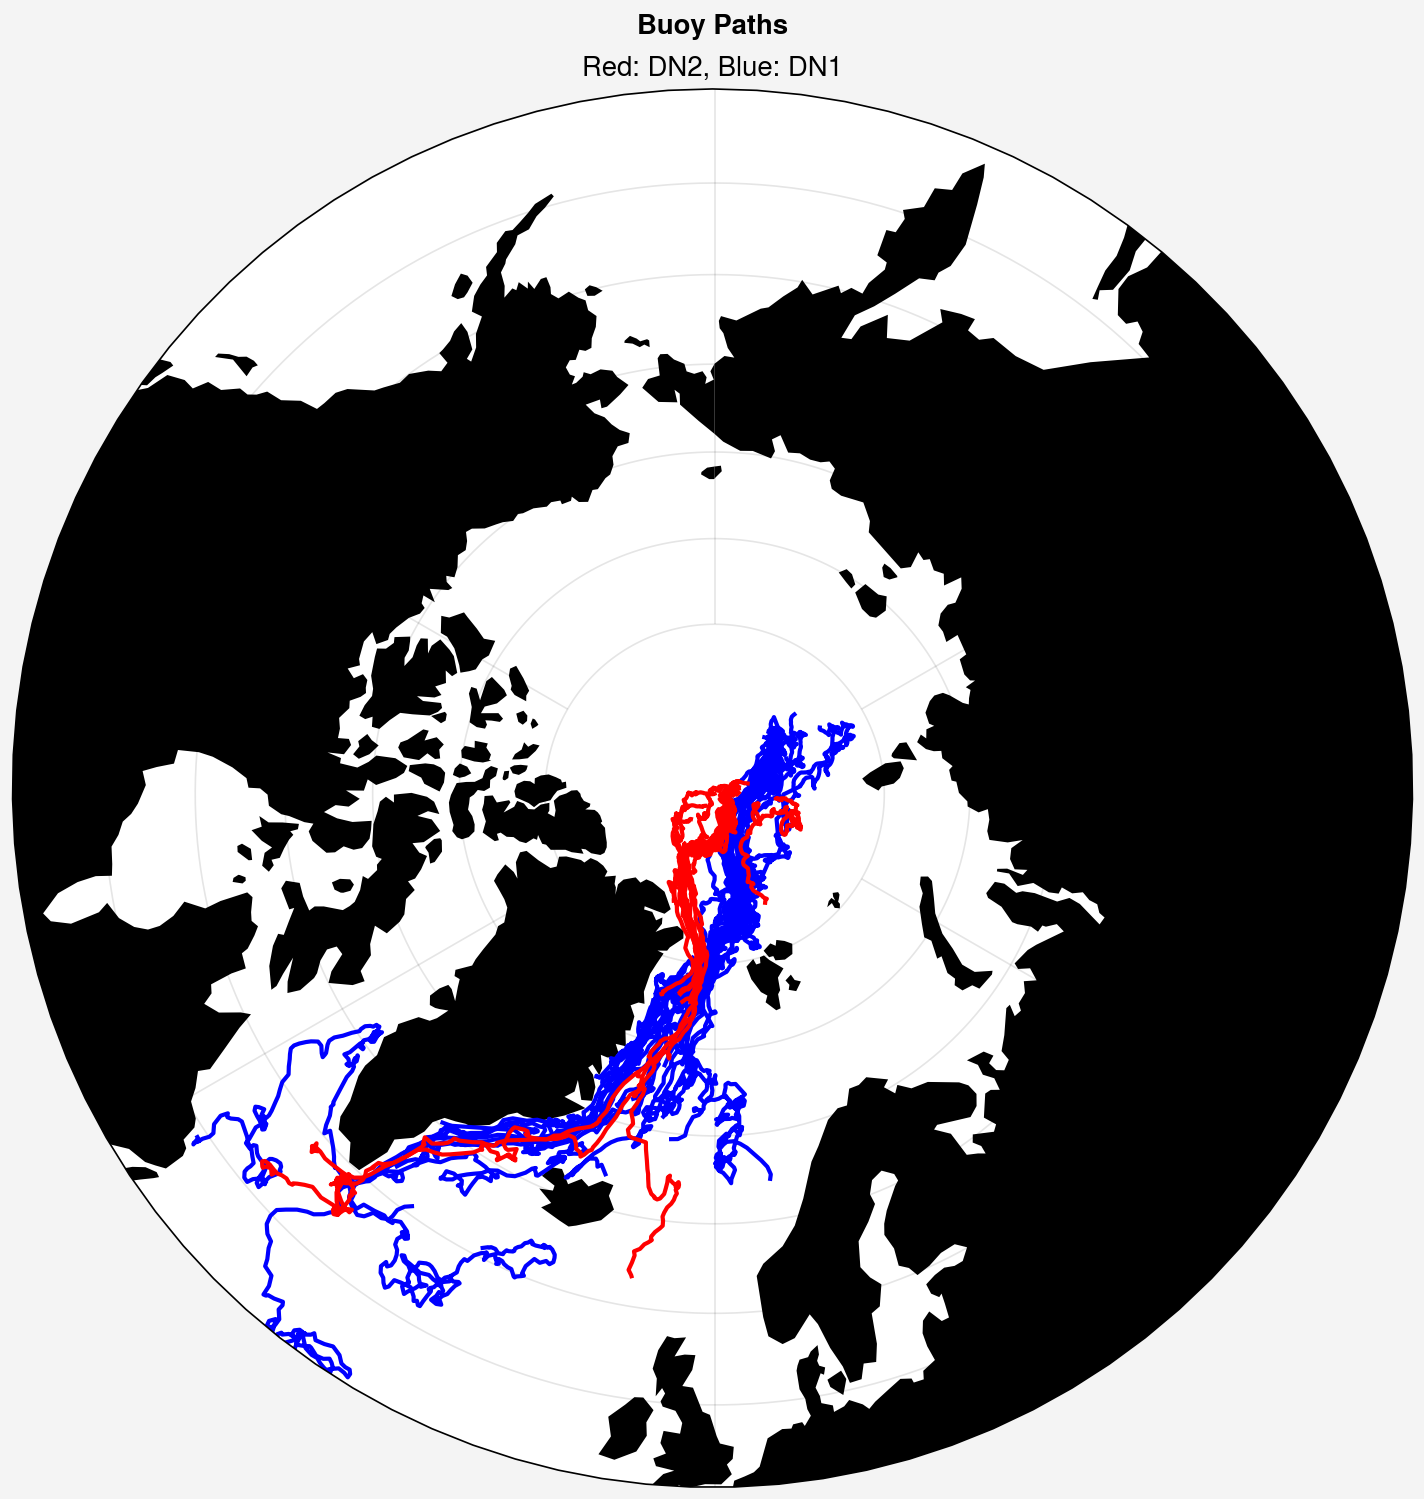

In [43]:
# Pole-centered map projections

fig, axs = pplt.subplots(ncols=1, refwidth=7, proj=('npstere'))
fig.format(suptitle='Buoy Paths')
axs.format(land=True)

dn1 = os.listdir("../data/daily_stations/mosaic_dn1")
dn2 = os.listdir("../data/daily_stations/mosaic_dn2")

axs[0].format(boundinglat=50, title='Red: DN2, Blue: DN1')

# Plot dn2 buoys in red, dn1 buoys in blue

for station in [i[:-4] for i in dn1]:
    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="blue")
for station in [i[:-4] for i in dn2]:
    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="red")

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, c

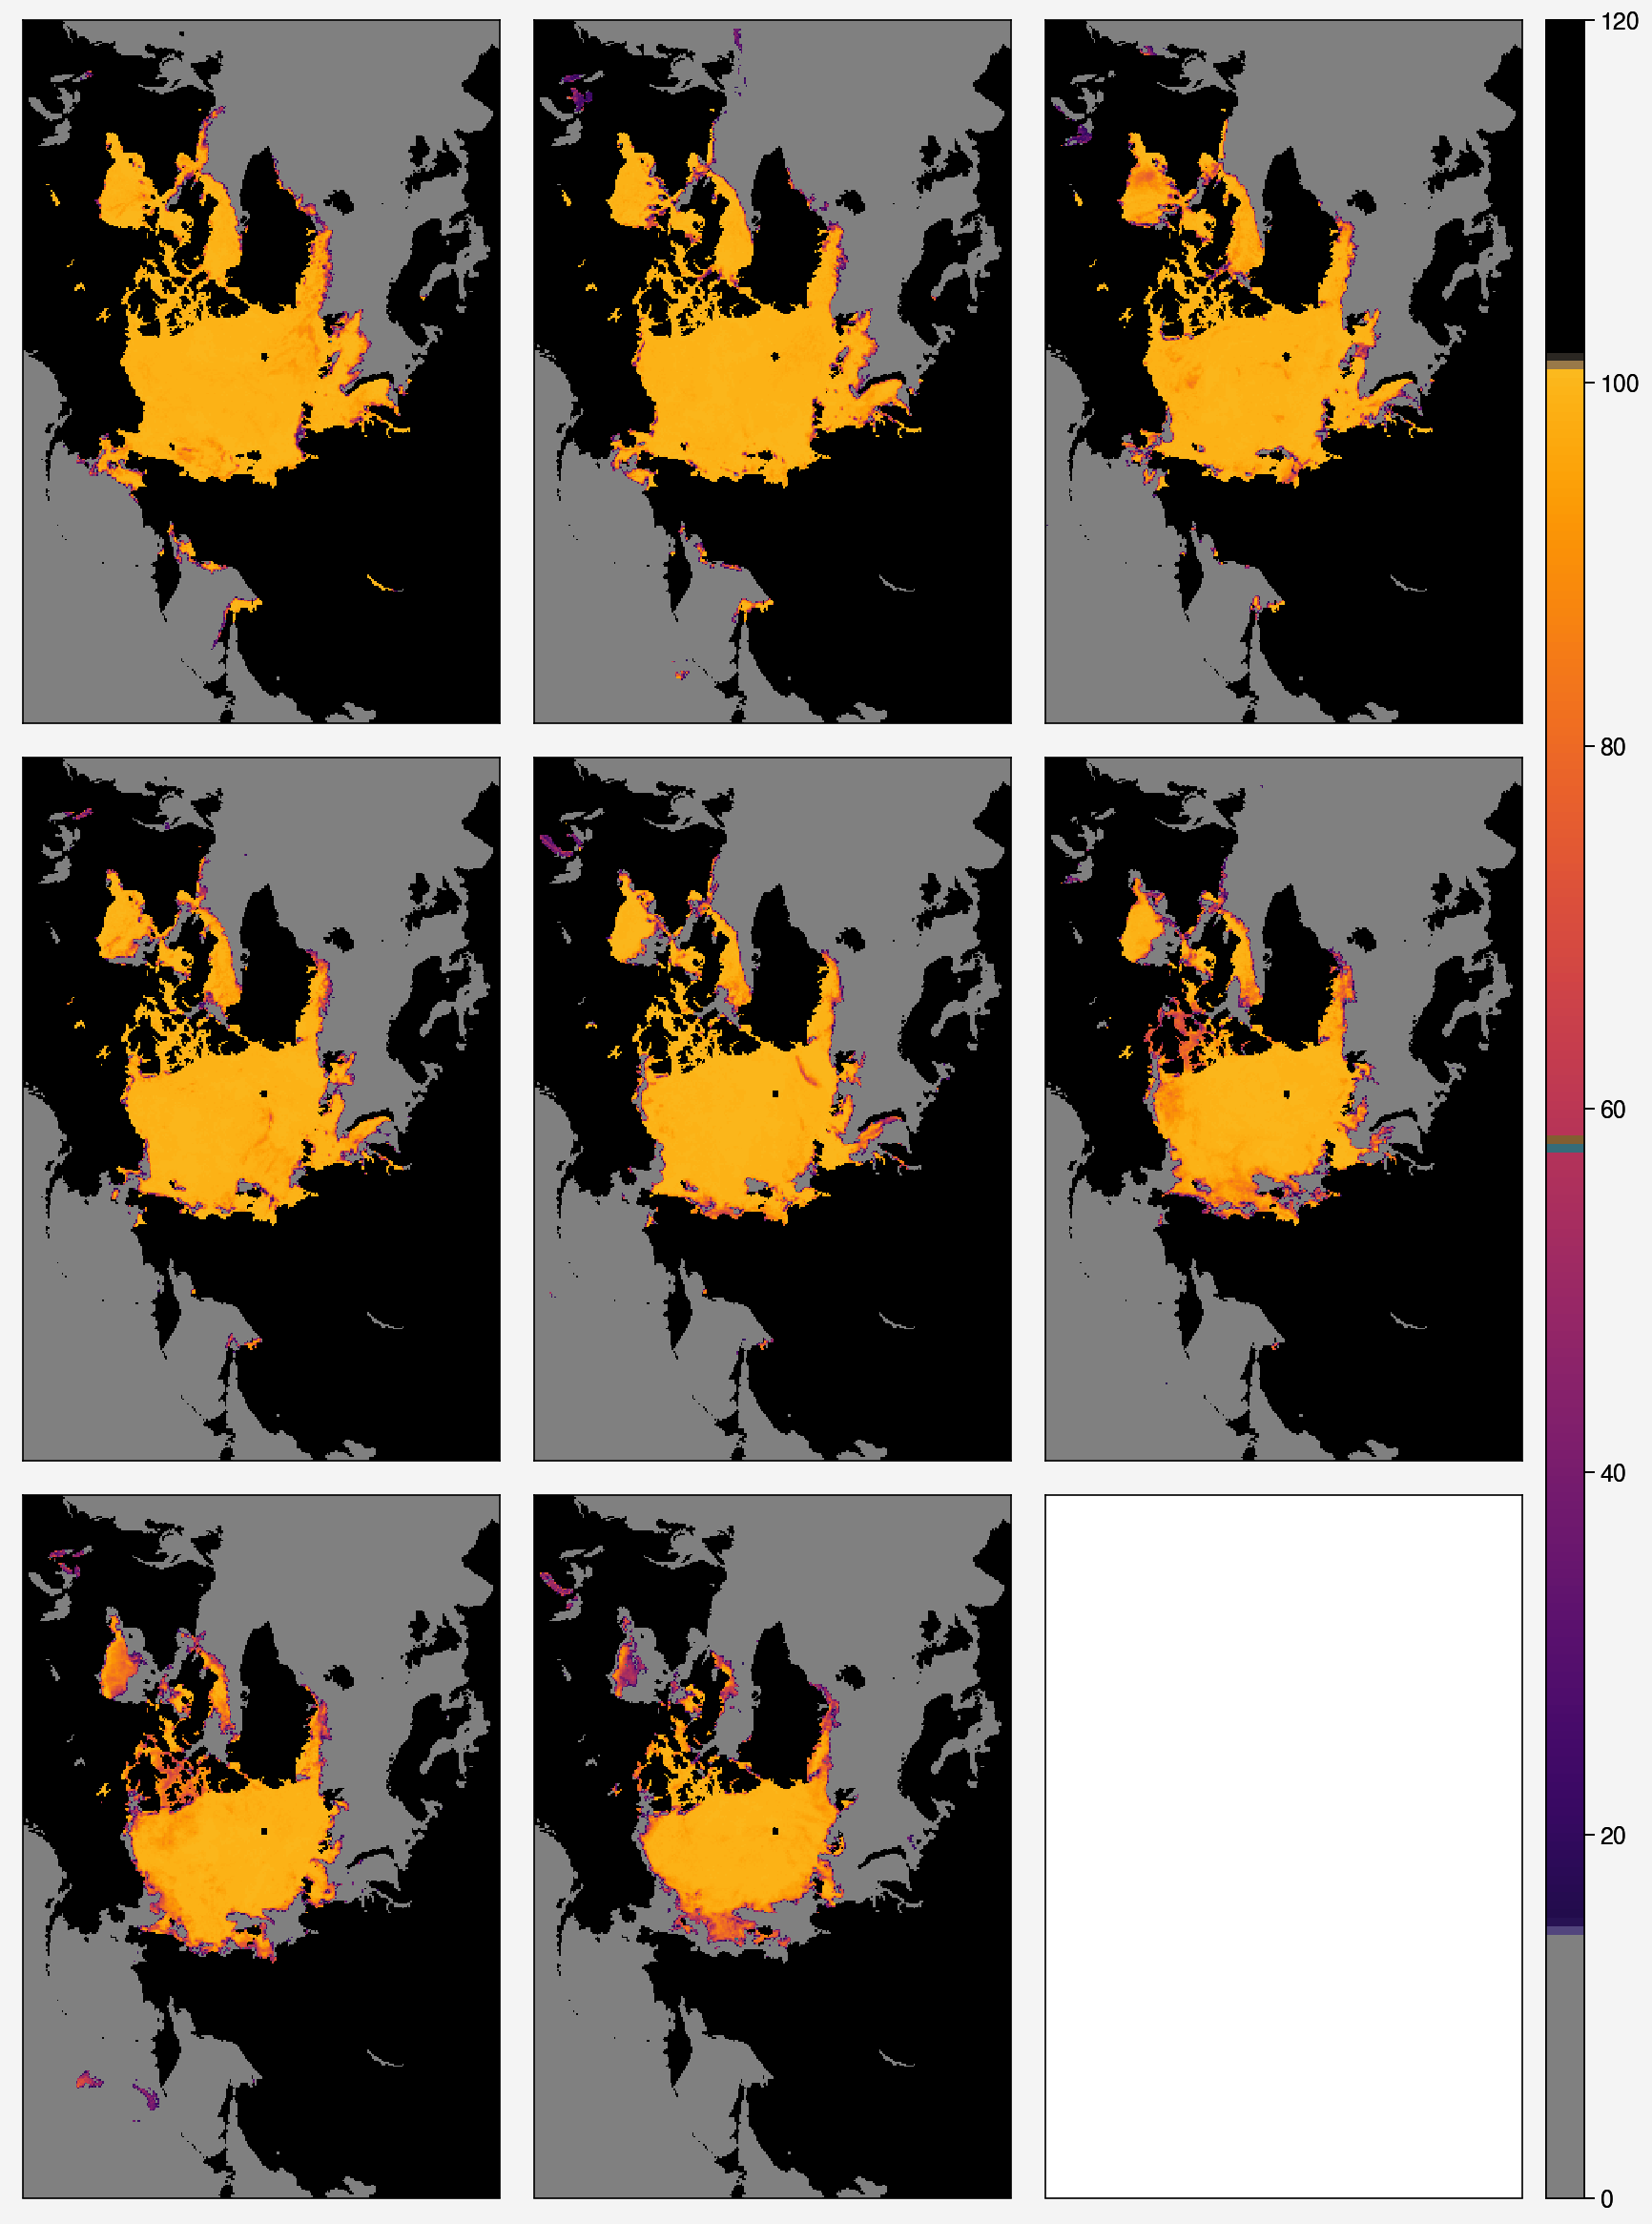

In [73]:
sic_data = xr.open_dataset("../data/amsr2_sea_ice_concentration.nc")
data = sic_data["sea_ice_concentration"].values

fig = pplt.figure()

cmap = pplt.Colormap('inferno')

newcolors = cmap(np.linspace(0, 1, 120))
# newcolors[:15] = np.array([0,61,153,1])
newcolors[:15] = np.array([0.5,0.5,0.5,1])
newcolors[101:] = np.array([0,0,0,1])

n = 8
dt = 10

ax = fig.subplots(nrows=(n+1)//3, ncols=3)

for i in range(n):
    h = ax[i].heatmap(data[dt*i], cmap=newcolors)

fig.colorbar(h, loc='r')
ax.format(xlocator='null', ylocator='null')